In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score

In [2]:
from datetime import datetime

def mostrar_tiempo(df):    
    dic_events_time = {}
    person = ""
    rows = []
    compra = False
    for index, row in df.iterrows():
        if(person == ""):
            person = row["person"]
            last_event_time = row['timestamp']
            continue            
        if(row['event'] == 'conversion'):
            compra = True
        tiempo = (datetime.strptime(last_event_time,"%Y-%m-%d %H:%M:%S") \
                                - datetime.strptime(row['timestamp'],"%Y-%m-%d %H:%M:%S")).total_seconds()
        if(tiempo > 86400):
            last_event_time = row['timestamp']
        if (row['new_vs_returning'] == 'New' or row['new_vs_returning'] == 'Returning' or person != row["person"]):
            if(row['person'] != person):
                tiempo = 0
            rows.append([person,tiempo,row['timestamp'],compra])
            person = ""
            compra = False
    return pd.DataFrame(rows,columns=('person', 'time_event', 'timestamp','realizo_compra'))

In [3]:
datos = pd.read_csv("events_up_to_01062018.csv",low_memory=False)


In [4]:
h = datos[['person','timestamp','event','new_vs_returning']]
h = h.sort_values(by=['person','timestamp'],ascending=False)
g = mostrar_tiempo(h)

In [5]:
g = g.sort_values(by='time_event',ascending=False)
g = g.loc[g['time_event']>0]

In [6]:
datos = pd.merge(datos,g,on=['person','timestamp'],how='left')

In [7]:
datos['timestamp'] = pd.to_datetime(datos['timestamp'])
datos['dia'] = datos['timestamp'].dt.day
datos['mes'] = datos['timestamp'].dt.month

In [8]:
quincenas = [False,0,2,4,6,8,10]

datos['mes_q'] = datos['mes'].apply(lambda x: quincenas[x])

datos['principio_fin'] = 0
datos.loc[datos['dia'] >15,'principio_fin'] = 1

datos['quincena'] = datos['principio_fin'] + datos['mes_q']

In [9]:
datos_tiempo = datos[['person','mes','time_event']]
datos_tiempo.fillna(0,inplace=True)
datos_tiempo = datos_tiempo.groupby(['person','mes']).agg({'time_event':'max'})

/home/mariano/ENTER/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [10]:
datos_tiempo = datos_tiempo.unstack()
datos_tiempo.columns = datos_tiempo.columns.droplevel(0)
datos_tiempo = datos_tiempo.reset_index(level=0,drop=False)


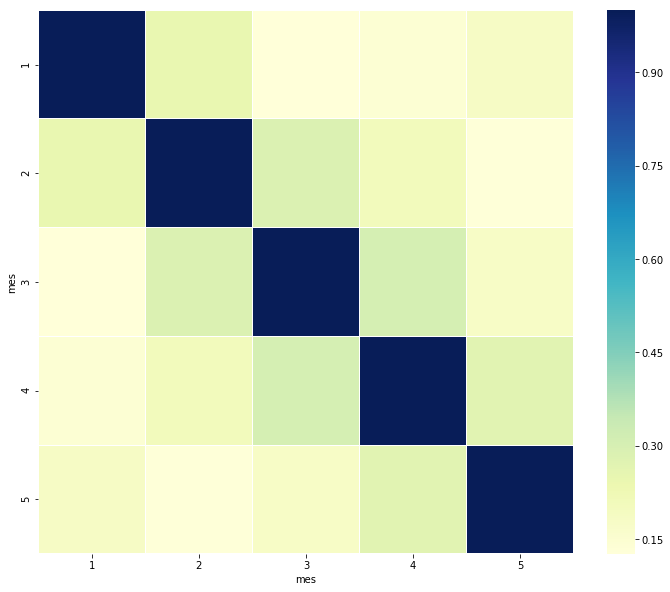

In [11]:

corrmat = datos_tiempo.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, ax=ax, cmap="YlGnBu", linewidths=0.1)

In [12]:
j = 0
for i in datos_tiempo.columns:
    datos_tiempo.rename(columns={j:'prom_tiempo_'+str(j)},inplace=True)
    j =  j + 1

In [13]:
datos_tiempo.fillna(0,inplace=True)

In [14]:
datos

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,screen_resolution,operating_system_version,browser_version,time_event,realizo_compra,dia,mes,mes_q,principio_fin,quincena
0,2018-05-18 00:11:59,viewed product,4886f805,NaN,9288.0,Samsung Galaxy J7 Prime,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
1,2018-05-18 00:11:27,viewed product,ad93850f,NaN,304.0,iPhone 5s,Muito Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
2,2018-05-18 00:11:16,viewed product,0297fc1e,NaN,6888.0,iPhone 6S,Muito Bom,64GB,Prateado,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
3,2018-05-18 00:11:14,viewed product,2d681dd8,NaN,11890.0,iPhone 7,Bom,128GB,Vermelho,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
4,2018-05-18 00:11:09,viewed product,cccea85e,NaN,7517.0,LG G4 H818P,Excelente,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
5,2018-05-18 00:44:27,searched products,4c8a8b93,NaN,NaN,NaN,NaN,NaN,NaN,"10240,9987,10322,10085,9944,9931,13404,10154,1...",...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
6,2018-05-18 00:44:14,viewed product,1b9f7cf6,NaN,2831.0,iPhone 6,Bom,16GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
7,2018-05-18 00:44:02,viewed product,29ebb414,NaN,2845.0,iPhone 6 Plus,Bom,128GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
8,2018-05-18 00:43:59,viewed product,de8fe91b,NaN,12548.0,Motorola Moto G5 Plus,Bom,32GB,Platinum,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9
9,2018-05-18 00:43:40,ad campaign hit,45baf068,/,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,18,5,8,1,9


In [15]:
compras = datos.loc[datos['event'] == 'conversion',['person','mes','timestamp']]
compras = compras.groupby(['person','mes']).count()

compras = compras.unstack().fillna(0)
compras.columns = compras.columns.droplevel(0)

j = 1
for i in compras.columns:
    compras.rename(columns={j:'compras_'+str(j)},inplace=True)
    j =  j + 1

In [16]:
#for i in compras_por_q:
#    compras.loc[compras[i]>0,i] = 1
#compras

In [17]:
eventos_x_person = datos[['person','event','timestamp']]
eventos_x_person = eventos_x_person.groupby(['person','event']).agg({'timestamp':'count'})
eventos_x_person = eventos_x_person.unstack(-1)
eventos_x_person.columns = eventos_x_person.columns.droplevel(0)
eventos_x_person = eventos_x_person.reset_index(level=0,drop=False)
eventos_x_person.fillna(0,inplace=True)

In [18]:
train = pd.read_csv("labels_training_set.csv",low_memory=False)

In [19]:
dat = pd.merge(compras,datos_tiempo,on='person')
train = pd.merge(train,dat,on='person')

In [20]:
train = pd.merge(train,eventos_x_person,on='person')

# IDEAS
-SI compro recientemente

-Hace cuanto no se loggea en la pagina

-Antiguedad en la pagina

### Features, gap entre compras y etc

Funcion que toma la distancia en dias de una compra y la siguiente sesión

In [21]:
def logueoycompras(df):
    rows=[]
    person = ""
    for index,row in df.iterrows():
        if((row['event'] == 'conversion') & (person == "")):
            dia_conversion = row['timestamp']
            person = row['person']
            continue
        if(person != ""):
            dias = row['timestamp'].timetuple().tm_yday -\
                dia_conversion.timetuple().tm_yday
            if(person!=row['person']):
                dias = datetime(2018, 6, 1, 0, 0).timetuple().tm_yday -\
                        dia_conversion.timetuple().tm_yday
                rows.append([person,dia_conversion.timetuple().tm_yday,dias])
                person = ""
                continue
            if dias >= 1:
                rows.append([person,dia_conversion.timetuple().tm_yday,dias])
                person = ""
    return pd.DataFrame(rows,columns=('person','day_of_year','dias_sin_conversion'))

Funcion que toma el gap entre compras desde registración hasta el 1ro de junio (en días)

In [22]:
def dist_compras(df):
    rows = []
    person = ""
    for index,row in df.iterrows():
        if(person != row['person']):
            if(person != ""):
                gap = (datetime(2018, 6, 1, 0, 0) - dia).total_seconds()
                rows.append([person,dia,gap])
            person = row['person']
            dia = row['timestamp']
        else:
            gap = (row['timestamp'] - dia).total_seconds()
            rows.append([person,dia,gap])
            dia = row['timestamp']
    return pd.DataFrame(rows,columns=('person','timestamp','distance'))

In [23]:
personas = datos[['person','new_vs_returning']]
personas = personas.loc[personas['new_vs_returning'] == 'New']

In [24]:
usuariosyregistros = datos[['person','timestamp']].sort_values(by=['person','timestamp'],ascending = True)\
                                                .drop_duplicates('person').merge(personas,on='person',how='left')                                                                                
print('Sin fecha registro : ',usuariosyregistros.new_vs_returning.isnull().sum())
usuariosyregistros.fillna('New',inplace=True)

Sin fecha registro :  587


In [25]:
datos = pd.merge(datos,usuariosyregistros,how='left',on=['person','timestamp'])
print('Sin registro: ',datos[['person','new_vs_returning_y']].sort_values(by='new_vs_returning_y')\
                                            .drop_duplicates('person').new_vs_returning_y.isnull().sum())
datos = datos.rename(columns={'new_vs_returning_y':'new_vs_returning'}).drop(columns='new_vs_returning_x')

Sin registro:  0


In [26]:
usuariosyregistros

,person,timestamp,new_vs_returning
0,0008ed71,2018-05-17 12:27:47,New
1,00091926,2018-05-03 22:08:29,New
2,00091a7a,2018-03-26 14:51:11,New
3,000ba417,2018-05-17 11:11:45,New
4,000c79fe,2018-05-29 00:27:47,New
5,000e4d9e,2018-05-16 11:54:55,New
6,000e619d,2018-05-15 18:20:08,New
7,001001be,2018-05-16 18:36:19,New
8,0010e89a,2018-05-30 18:18:34,New
9,0016c4b5,2018-05-29 18:47:57,New


In [27]:
compradores = datos[['person','timestamp','event']].sort_values(by=['person','timestamp'])
compradores = compradores.loc[compradores['event']=='conversion',['person','timestamp']]
sesion_comprar = compradores.append(usuariosyregistros)
sesion_comprar =sesion_comprar.reset_index(drop=True)
sesion_comprar.drop(columns='new_vs_returning',inplace=True)
sesion_comprar.sort_values(by=['person','timestamp'],inplace=True)

/home/mariano/ENTER/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [28]:
sesion_comprar['timestamp'] = pd.to_datetime(sesion_comprar['timestamp'])
distancias = dist_compras(sesion_comprar)
distancias['distance']/= (60*60*24)

In [29]:
distancias

,person,timestamp,distance
0,0008ed71,2018-05-17 12:27:47,14.480706
1,00091926,2018-05-03 22:08:29,28.077442
2,00091a7a,2018-03-26 14:51:11,66.381123
3,000ba417,2018-05-17 11:11:45,9.081678
4,000ba417,2018-05-26 13:09:22,5.451829
5,000c79fe,2018-05-29 00:27:47,2.980706
6,000e4d9e,2018-05-16 11:54:55,15.503530
7,000e619d,2018-05-15 18:20:08,16.236019
8,001001be,2018-05-16 18:36:19,0.037975
9,001001be,2018-05-16 19:31:00,15.186806


In [30]:
hace_cuanto_no_convierte = distancias.sort_values(by='timestamp',ascending=False).\
                                            drop_duplicates('person').drop(columns='timestamp').\
                                                rename(columns={'distance':'dias_sin_convertir'})
max_sin_convertir = distancias[['person','distance']].groupby('person').max().reset_index().\
                                                    rename(columns={'distance':'max_sin_convertir'})
promedio_dias_conversion = distancias[['person','distance']].groupby('person').mean().reset_index().\
                                                    rename(columns={'distance':'convierte_cada_x_dias'})

In [31]:
personas = datos[['person','timestamp','new_vs_returning']]
personas = personas.loc[personas['new_vs_returning'] == 'New']
personas['registration_day'] = personas['timestamp'].dt.dayofyear
personas.drop(columns=['new_vs_returning','timestamp'],inplace=True)

In [32]:
new_columns_days = pd.merge(personas,max_sin_convertir,how='left',on='person')
new_columns_days = pd.merge(new_columns_days,hace_cuanto_no_convierte,how='left',on='person')
new_columns_days.loc[(new_columns_days['max_sin_convertir'].isnull()) | (new_columns_days['dias_sin_convertir'].\
            isnull()),['max_sin_convertir','dias_sin_convertir']] = 152 - new_columns_days['registration_day']
new_columns_days = pd.merge(new_columns_days,promedio_dias_conversion,how='left',on='person')
new_columns_days.fillna(0,inplace=True)


In [33]:
new_columns_days.isnull().sum()

person                   0
registration_day         0
max_sin_convertir        0
dias_sin_convertir       0
convierte_cada_x_dias    0
dtype: int64

In [34]:
new_columns_days['registration_day'] = datetime(2018, 6, 1, 0, 0).timetuple().tm_yday\
                                                                        - new_columns_days['registration_day']
new_columns_days.rename(columns={'registration_day':'antiguedad'},inplace=True)
train = pd.merge(train,new_columns_days,on='person')

In [35]:
train.isnull().sum()

person                   0
label                    0
compras_1                0
compras_2                0
compras_3                0
compras_4                0
compras_5                0
prom_tiempo_1            0
prom_tiempo_2            0
prom_tiempo_3            0
prom_tiempo_4            0
prom_tiempo_5            0
ad campaign hit          0
brand listing            0
checkout                 0
conversion               0
generic listing          0
lead                     0
search engine hit        0
searched products        0
staticpage               0
viewed product           0
visited site             0
antiguedad               0
max_sin_convertir        0
dias_sin_convertir       0
convierte_cada_x_dias    0
dtype: int64

In [36]:
features = train.iloc[:,2:].columns

In [37]:
from sklearn.model_selection import train_test_split

test_s = 0.20
random_s = 0

x = np.array(train[train.iloc[:,2:].columns])
y = np.array(train['label'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_s, random_state=random_s)

In [38]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score

print('VALORES INICIALES PARA K')

k_valores = [5,7,10,20,50]
mejor_k = 0
mejor_precision = 0

for k in k_valores:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    precision = roc_auc_score(np.array(y_test), pred)
    print('La precisión para k=', k, 'es:',precision)
    if precision > mejor_precision:
        mejor_precision = precision
        mejor_k = k
        
print('Con k=', mejor_k, 'se obtuvo la mayor precisión:', mejor_precision)

VALORES INICIALES PARA K
La precisión para k= 5 es: 0.6429416686588572
La precisión para k= 7 es: 0.5945075304805164
La precisión para k= 10 es: 0.5615646665072913
La precisión para k= 20 es: 0.5040222328472388
La precisión para k= 50 es: 0.5
Con k= 5 se obtuvo la mayor precisión: 0.6429416686588572


In [44]:
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    precision = roc_auc_score(np.array(y_test), pred)
    print('La precisión para k=1 es:',precision)

La precisión para k=1 es: 0.9390329906765479


In [39]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier, ExtraTreesClassifier,\
                             BaggingClassifier, VotingClassifier)
rnd_clf = RandomForestClassifier(n_estimators = 100 , criterion = 'entropy',random_state = 0)
rnd_clf.fit(train.iloc[:,2:],train['label'])

/home/mariano/ENTER/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [40]:
for name, importance in zip(features, rnd_clf.feature_importances_):
    print('"' + name + '"'+" : ",importance,',')

"compras_1" :  0.001319500437203228 ,
"compras_2" :  0.0019633326336883296 ,
"compras_3" :  0.012155088825202238 ,
"compras_4" :  0.006401705599171919 ,
"compras_5" :  0.048223674323489216 ,
"prom_tiempo_1" :  0.00912890213299719 ,
"prom_tiempo_2" :  0.00939434516915745 ,
"prom_tiempo_3" :  0.020500887029496772 ,
"prom_tiempo_4" :  0.02738433857892543 ,
"prom_tiempo_5" :  0.08271659180980966 ,
"ad campaign hit" :  0.05148563594783483 ,
"brand listing" :  0.058392420530038666 ,
"checkout" :  0.04614017904008717 ,
"conversion" :  0.021285324842699453 ,
"generic listing" :  0.054508009553802736 ,
"lead" :  0.005519381947807121 ,
"search engine hit" :  0.04179692158209882 ,
"searched products" :  0.040043113682381885 ,
"staticpage" :  0.02226815692765767 ,
"viewed product" :  0.07028814591634658 ,
"visited site" :  0.04437633229419082 ,
"antiguedad" :  0.06407818343159277 ,
"max_sin_convertir" :  0.0758583719370817 ,
"dias_sin_convertir" :  0.11471963434929808 ,
"convierte_cada_x_dias" :  

In [41]:
train.to_csv('train_final.csv', encoding='utf-8', index=False)